<a href="https://colab.research.google.com/github/HygorSantiago/FutIA/blob/main/1_VA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelagem do Variational Autoencoder



## Bibliotecas utilizadas

In [1]:
# Numpy

from numpy import expand_dims, prod
import numpy as np

# TensorFlow

from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.saved_model import save, load


# MatPlotLib

import matplotlib.pyplot as plt

# Sklearn

from sklearn.model_selection import train_test_split

In [2]:
# Conexão com o Google Drive.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Funções

In [3]:
# Carrega o banco de dados MNIST.
def mnist_database():

    (x_train, y_train), (x_test, y_test) = load_data()

    x_train = expand_dims(x_train, axis=-1).astype('float32')/255
    x_test = expand_dims(x_test, axis=-1).astype('float32')/255

    return (x_train, y_train), (x_test, y_test)

# Reduz o banco de dados.
def reduct_database(x_train, y_train, test_size):

    try:
        x_train_full, x_train_small, y_train_full, y_train_small = train_test_split(
            x_train, y_train, test_size=test_size, stratify=y_train)
        return x_train_small, y_train_small

    except:
        return x_train, y_train

# Insere ruído nas amostras.
def noise(x_train, noise_factor):
    noisy_sample = x_train + np.random.normal(loc=0.0, scale=noise_factor, size=x_train.shape)
    noisy_sample = np.clip(noisy_sample, 0.0, 1.0)
    return noisy_sample

# Plota as imagens.
def plot_image(image,save='no'):

    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    if save != 'no':
        plt.tight_layout()
        plt.savefig(save)
    plt.show()

# Função para amostrar do espaço latente.
def sampling(args):

    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0, stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2 ) * epsilon

# Modelagem e treinamento do Variational Autoencoder.
def vae_train(train,test,latent_dim = 2,epsilon_std = 1.0,epochs=2,summary_plot=False):

    # Parâmetros iniciais.
    original_dim = (train.shape[1],train.shape[2],train.shape[3])
    batch_size = 100

    # Encoder.
    encoder_input = Input(shape=original_dim,name='input_encoder')
    encoder_h = Conv2D(8, (3, 3), activation='relu', padding='same',name='conv_1')(encoder_input)
    encoder_h = Dropout(0.1)(encoder_h)
    encoder_h = MaxPooling2D((2, 2), padding='same',name='pooling_1')(encoder_h)
    encoder_h = Conv2D(16, (3, 3), activation='relu', padding='same',name='conv_2')(encoder_h)
    encoder_h = Dropout(0.1)(encoder_h)
    encoder_h = MaxPooling2D((2, 2), padding='same',name='pooling_2')(encoder_h)
    conv_shape = (encoder_h.shape[1],encoder_h.shape[2],encoder_h.shape[3])
    encoder_h = Flatten(name='flatten')(encoder_h)
    flatten_shape = encoder_h.shape[1]
    encoder_h = Dense(256, activation='relu',name='dense_1')(encoder_h)
    encoder_h = Dropout(0.1)(encoder_h)

    z_mean = Dense(latent_dim,name='z_mean')(encoder_h)
    z_log_var = Dense(latent_dim,name='z_log_var')(encoder_h)
    z = Lambda(sampling, output_shape=(latent_dim,),name='latent_space')([z_mean, z_log_var])

    # Decoder.
    decoder_h = Dense(256, activation='relu',name='dense_2')
    h_decoded1 = decoder_h(z)
    h_decoded2 = Dropout(0.1)(h_decoded1)
    h_decoded3 = Dense(flatten_shape, activation='sigmoid',name='dense_3')(h_decoded2)
    h_decoded4 = Dropout(0.1)(h_decoded3)
    h_decoded5 = Reshape(conv_shape,name='reshape')(h_decoded4)
    h_decoded6 = UpSampling2D((2, 2),name='upsampling_1')(h_decoded5)
    h_decoded7 = Conv2D(8, (3, 3), activation='relu', padding='same',name='conv_3')(h_decoded6)
    h_decoded8 = Dropout(0.1)(h_decoded7)
    h_decoded9 = UpSampling2D((2, 2),name='upsampling_2')(h_decoded8)
    h_decoded = Conv2D(1, (3, 3), activation='relu', padding='same',name='conv_4')(h_decoded9)

    # Funções de custo.
    xent_loss = prod(original_dim)*K.mean(binary_crossentropy(K.flatten(encoder_input),
                                                              K.flatten(h_decoded)))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)

    # Compilação do VAE.
    vae = Model(encoder_input, h_decoded)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='rmsprop')

    if summary_plot:
        vae.summary()

    # Treinamento.
    vae.fit(x_train, x_train,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size)

    # Avaliação.
    result = vae.evaluate(test, test)
    print(result)

    # Construir o modelo do encoder.
    encoder = Model(encoder_input, z_mean)

    # Aqui está o problema.

    # Construir o modelo do decoder.
    #decoder_input = Input(shape=(latent_dim,))
    #h = decoder_h(decoder_input)
    #h = h_decoded(h)
    #generator = Model(decoder_input, h)

    vae.save('/content/drive/MyDrive/vae.h5')
    encoder.save('/content/drive/MyDrive/encoder.h5')
    #generator.save('/content/drive/MyDrive/generator.h5')

    return vae



## Código principal

In [4]:
# Carregar dados MNIST.
(x_train, y_train), (x_test, y_test) = mnist_database()

#x_train, y_train = reduct_database(x_train, y_train, 0.1)

x_train.shape

11490434/11490434 [==============================] - 1s 0us/step


(60000, 28, 28, 1)

In [5]:
# Treina o VAE.
latent_dim = 8
epsilon_std = 1.0

vae = vae_train(x_train,x_test,
                latent_dim = latent_dim,
                epsilon_std = epsilon_std,
                epochs=2,
                summary_plot=False)

vae.save('/content/drive/MyDrive/60000ls8.h5')

Epoch 1/2
600/600 [==============================] - 19s 9ms/step - loss: 226.2351
Epoch 2/2
313/313 [==============================] - 1s 3ms/step - loss: 143.8877
143.88766479492188


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [65]:
vae = load_model('/content/drive/MyDrive/60000ls8.h5')

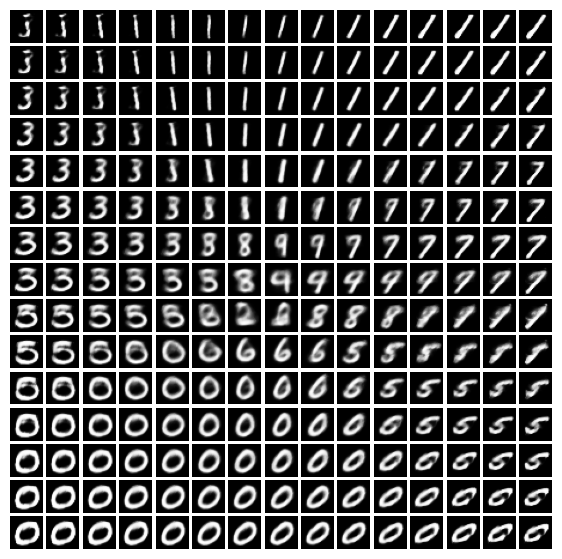

In [ ]:
# Amostragem das imagens criadas pra um Espaço Latente de 2.
import numpy as np
import matplotlib.pyplot as plt

n1 = 15
n2 = 15
# Crie uma figura com 5x5 subplots
fig, axs = plt.subplots(n1, n2, figsize=(7, 7))

# Itere sobre os valores de i e j
for i, x in enumerate(np.linspace(-4, 4, n1)):
    for j, y in enumerate(np.linspace(-4, 4, n2)):
        # Gere uma imagem com o gerador
        generated_image = generator.predict([[x, y]],verbose=0)
        generated_image = generated_image.reshape(28, 28)

        # Plote a imagem no subplot correspondente
        axs[i, j].imshow(generated_image, cmap='Greys_r')
        axs[i, j].axis('off')  # Desligue os eixos

# Ajuste os espaços entre subplots para torná-los mais legíveis
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Mostre o grid de imagens
plt.show()
